In [1]:
import numpy as np
import torch as th
import glob, os
import matplotlib.pyplot as plt
from PIL import Image
import torchvision

def sort_by_frame(path_list):
    frame_anno = []
    for p in path_list:
        frame_idx = os.path.splitext(p.split('/')[-1].split('_')[-1])[0][5:]   # 0-4 is "frame", so we used [5:] here
        frame_anno.append(int(frame_idx))
    sorted_idx = np.argsort(frame_anno)
    sorted_path_list = []
    for idx in sorted_idx:
      sorted_path_list.append(path_list[idx])
    return sorted_path_list

path = '/data/mint/sampling/TPAMI/cast_shadows_results/log=DiFaReli_FsBg_Sdiff_SS_128_VLL_cfg=DiFaReli_FsBg_Sdiff_SS_128_VLL.yaml_inv_with_sd_rotateSH_axis2_SSdat/ema_100000/valid/render_face/reverse_sampling/src=64847.jpg/dst=60000.jpg/Lerp_1000/n_frames=60'
sd = sort_by_frame(glob.glob(path + '/shadm_shad_frame*.png'))

sd_img = [th.tensor(np.array(Image.open(p))) for p in sd]
sd_img = th.stack(sd_img, dim=0)
sd_img = th.cat((sd_img, th.flip(sd_img, dims=[0])), dim=0)

torchvision.io.write_video('shadm_shad.mp4', sd_img, 20)


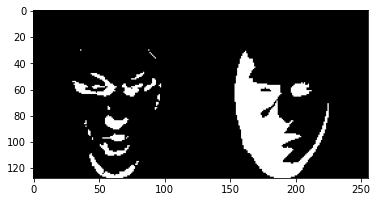

(8, 128, 128, 1) (32, 128, 128, 1)
[#] Total frames :  (40, 128, 128, 3)
[#] Verifying the first frame and last frame
(128, 128, 1) (128, 128, 3) (128, 128, 3) (128, 128, 1)
True


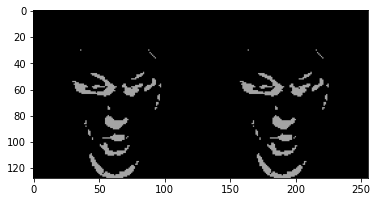

True


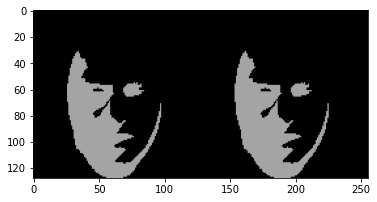

In [82]:
# Erosion
from scipy import ndimage
import cv2

sd_img = [(np.array(Image.open(p)))/255. for p in sd]
sdiff = sd_img[0][..., 0:1]
sm = sd_img[1][..., 0:1]
plt.imshow(np.concatenate((sdiff, sm), axis=1), cmap='gray')
plt.show()


def erode(sdiff, upsampling_factor=1, aa=False):
    tmp = sdiff
    out = [tmp]

    if upsampling_factor > 1:
        tmp = cv2.resize(tmp, (tmp.shape[1] * upsampling_factor, tmp.shape[0] * upsampling_factor), interpolation=cv2.INTER_NEAREST)
        erosion_size = 4
    else: 
        erosion_size = 2
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * erosion_size + 1, 2 * erosion_size + 1),
                                    (erosion_size, erosion_size))
    # print(element.shape)
    # plt.imshow(element)
    # plt.show()
    while len(np.unique(tmp)) > 1:
        # sdiff_erosion = ndimage.binary_erosion(tmp, iterations=1)
        # sdiff_erosion = ndimage.binary_dilation(tmp, iterations=1, mask=~mask)
        # sdiff_erosion = cv2.erode(tmp, np.ones((3, 3), np.uint8), iterations=1)
        sdiff_erosion = cv2.erode(tmp, kernel=element, iterations=1)
        # sdiff_erosion = ndimage.grey_dilation(tmp, size=(3, 3, 3))
        # sdiff_erosion = ndimage.binary_dilation(tmp, iterations=1, structure=np.ones((3, 3, 3), dtype=bool))
        # print("Input : ", np.unique(tmp))
        # print("Output : ", np.unique(sdiff_erosion))
        tmp = sdiff_erosion
        # print("=" * 100)
        if upsampling_factor > 1:
            if aa:
                sdiff_erosion = cv2.resize(sdiff_erosion, (sdiff_erosion.shape[1] // upsampling_factor, sdiff_erosion.shape[0] // upsampling_factor), interpolation=cv2.INTER_AREA)
            else:
                sdiff_erosion = cv2.resize(sdiff_erosion, (sdiff_erosion.shape[1] // upsampling_factor, sdiff_erosion.shape[0] // upsampling_factor), interpolation=cv2.INTER_NEAREST)

        if len(sdiff_erosion.shape) == 2:
            sdiff_erosion = sdiff_erosion[..., None]
        out.append(sdiff_erosion)



    # print(len(out))
    # plt.figure(figsize=(10, 10))
    # out_vis = np.concatenate(out, axis=1)
    # plt.imshow((out_vis), cmap='gray')
    # plt.show()
    return out

sdiff_erd = erode(sdiff, upsampling_factor=8, aa=True)
sm_erd = erode(sm, upsampling_factor=8, aa=True)

sdiff_erd = np.stack(sdiff_erd, axis=0)
sm_erd = np.stack(sm_erd, axis=0)
print(sdiff_erd.shape, sm_erd.shape)

smooth = np.concatenate((sdiff_erd, sm_erd[::-1]), axis=0)
smooth = np.repeat(smooth, 3, axis=-1)
print("[#] Total frames : ", smooth.shape)
torchvision.io.write_video('shadm_shad_erode_aa.mp4', th.tensor(smooth)*255, 20)
print("[#] Verifying the first frame and last frame")

print(sdiff.shape, smooth[0].shape, smooth[-1].shape, sm.shape)
print(np.all(sdiff == smooth[0][..., 0:1]))
plt.imshow(np.concatenate((np.repeat(sdiff, 3, axis=-1), smooth[0]), axis=1))
plt.show()
print(np.all(sm == smooth[-1][..., 0:1]))
plt.imshow(np.concatenate((np.repeat(sm, 3, axis=-1), smooth[-1]), axis=1))
plt.show()

[0]


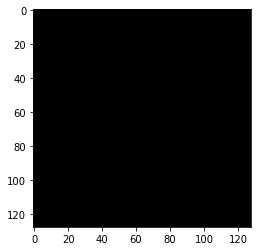

In [10]:
radius = 50

structuring_element = np.zeros((L, L, 3), dtype=bool) * 1
rr, cc = np.ogrid[:128, :128]
circle = (rr - radius)**2 + (cc - radius)**2 <= radius**2
structuring_element[circle] = False
print(np.unique(structuring_element))
plt.imshow(structuring_element, cmap='gray')
plt.show()